# Analyzing the avGFP landscape

**WARNING: this example notebook uses an outdated version of the library API. See the documentation for more details.**
This example walks through the generation of analysis figures for the avGFP brightness landscape, similar to how they were generate ``Interpretable modeling of genotype-phenotype landscapes with state-of-the-art predictive power''.

In [1]:
import matplotlib.pyplot as plt

%matplotlib inline

## Prepare the model

First we load the dataset and pre-trained model file. The dataset for avGFP can be generated from the manuscript pipeline found at [https://github.com/usnistgov/lantern/tree/master/manuscript](github.com/usnistgov/lantern/tree/master/manuscript). The pre-trained model parameters are also provided there.

First, we load the csv dataset and prepare it as a `LANTERN` dataset.

In [2]:
import pandas as pd

from lantern.dataset import Dataset

df = pd.read_csv("../manuscript/data/processed/gfp.csv", index_col=0)
df.head()

,aaMutations,uniqueBarcodes,medianBrightness,std,substitutions,phenotype,cv
0,NaN,3645,3.719212,0.106992,NaN,1.030462,1.0
1,SA108D,1,1.301030,NaN,SA108D,-1.250280,7.0
2,SA108D:SN144D:SI186V:SM231T:SL234P,1,1.301031,NaN,SA108D:SN144D:SI186V:SM231T:SL234P,-1.250279,9.0
3,SA108D:SY141N:SH146L:SE220G,1,1.301189,NaN,SA108D:SY141N:SH146L:SE220G,-1.250130,8.0
4,SA108G,2,3.708478,0.020613,SA108G,1.020338,8.0


In [3]:
ds = Dataset(df)
ds

Dataset(substitutions='substitutions', phenotypes=['phenotype'], errors=None)

Then we setup the `LANTERN` model, and load the pre-trained model parameters.

In [4]:
from lantern.model.basis import VariationalBasis
from lantern.model.surface import Phenotype
from lantern.model import Model

import torch

K=8
model = Model(
    VariationalBasis.fromDataset(ds, K=K),
    Phenotype.fromDataset(ds, K=K)
)

model.load_state_dict(
    torch.load(
        "../manuscript/experiments/gfp-brightness/lantern/full/model.pt",
        "cpu"
    )
)

model.eval();

## Plot the avGFP brightness surface

We first plot the non-linear surface across $z_1$ and $z_2$ by:
1. Finding the range of values observed for $z_1$ and $z_2$ across the dataset.
2. Building a dense mesh of points covering the range of values in these two dimensions.
3. Predicting the surface at these points
4. Plotting the surface contours

In [5]:
import numpy as np

# find z1, z2
z1, z2 = model.basis.order[:2]

# get mutations and brightness for all observations
X, y = ds[:len(ds)]

# get the embedding for all data points
with torch.no_grad():
    Z = model.basis(X)

# to filter outliers, only plot the points within [q/2, 1-q/2] quantile of each latent dimension
q = 0.01

# number of surface points
N = 100

# the meshgrid is used for surface plotting
Z1, Z2 = np.meshgrid(
    np.linspace(np.quantile(Z[:, z1], q/2), np.quantile(Z[:, z1], 1 - q/2), N),
    np.linspace(np.quantile(Z[:, z2], q/2), np.quantile(Z[:, z2], 1 - q/2), N )
)

# predict the surface at each meshgrid point
Zpred = torch.zeros(N**2, model.basis.K)
Zpred[:, z1] = torch.from_numpy(Z1.ravel())
Zpred[:, z2] = torch.from_numpy(Z2.ravel())

# predict the surface
with torch.no_grad():
    fpred = model.surface(Zpred)
    
# scale to original brightness values and reshape for plotting
f = fpred.mean * df["medianBrightness"].std() + df["medianBrightness"].mean()
f = f.reshape(Z1.shape)

# also scale the data for plotting
y = y * df["medianBrightness"].std() + df["medianBrightness"].mean()

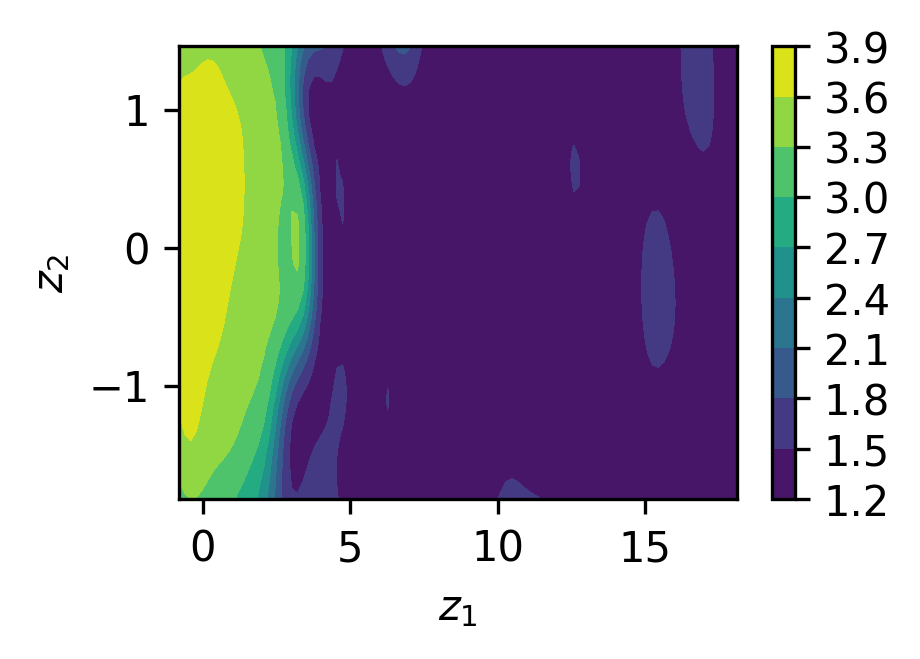

In [6]:
plt.figure(figsize=(3,2), dpi=300)

im = plt.contourf(Z1, Z2, f, levels=8)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$")
plt.colorbar()

Next, we add the scatter of measured datapoints for comparison, coloring them by their measured value.

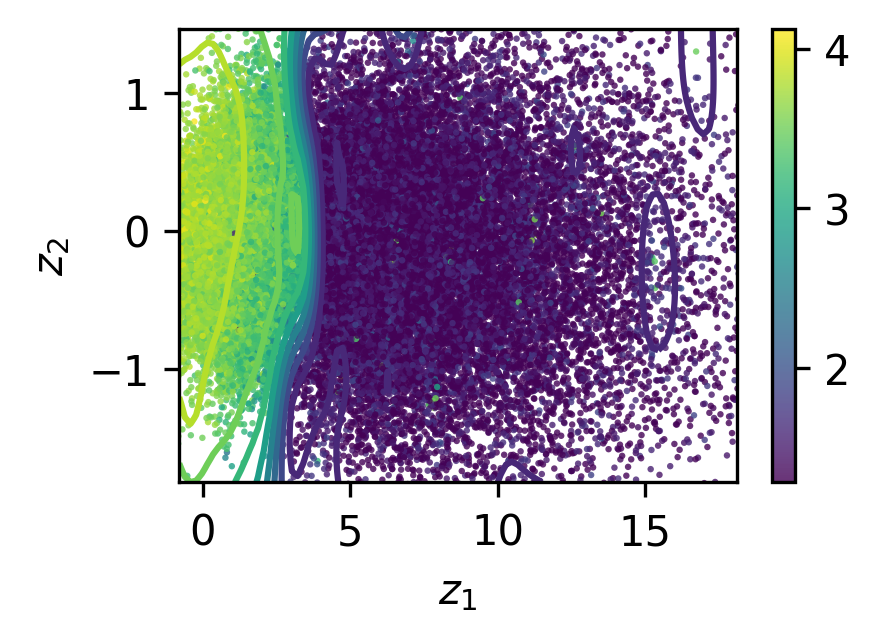

In [7]:
plt.figure(figsize=(3,2), dpi=300)

im = plt.contour(Z1, Z2, f, levels=8)
plt.scatter(Z[:, z1].numpy(), Z[:, z2].numpy(), c = y, alpha=0.8, s=0.3, rasterized=True)

# re-apply the limits
plt.xlim(np.quantile(Z[:, z1], q/2), np.quantile(Z[:, z1], 1 - q/2))
plt.ylim(np.quantile(Z[:, z2], q/2), np.quantile(Z[:, z2], 1 - q/2))

plt.xlabel("$z_1$")
plt.ylabel("$z_2$")
plt.colorbar()

## Highlighting mutations in the surface

To highlight specific mutations in the surface, we find the mutation effect vectors in the matrix $W$ and plot them over the surface contour. We re-calculate the contour predictions on the more narrow focused region around the origin. The mutations shown here are previously identified stabilizing substitutions for the blue fluorescent derivative of avGFP (BFP).

In [8]:
# BFP stabilizing mutations
subs = ["SY143F", "SS63T", "SH229L",'SY37N', 'SN103T', 'SY143F', 'SI169V', 'SN196S', 'SA204V']
labels = [s[1:] for s in subs]
ind = [ds.tokenizer.tokens.index(s) for s in subs]

In [9]:
# Get average mutation effects
W = model.basis.W_mu.detach().numpy()

In [10]:
# rebuid the surface in a focused region
Z1, Z2 = np.meshgrid(
    np.linspace(-1.7, 2.6, N),
    np.linspace(-0.6, 0.3, N )
)

# predict the surface at each meshgrid point
Zpred = torch.zeros(N**2, model.basis.K)
Zpred[:, z1] = torch.from_numpy(Z1.ravel())
Zpred[:, z2] = torch.from_numpy(Z2.ravel())

# predict the surface
with torch.no_grad():
    fpred = model.surface(Zpred)
    
# scale to original brightness values and reshape for plotting
f = fpred.mean * df["medianBrightness"].std() + df["medianBrightness"].mean()
f = f.reshape(Z1.shape)

Text(0, 0.5, '$z_2$')

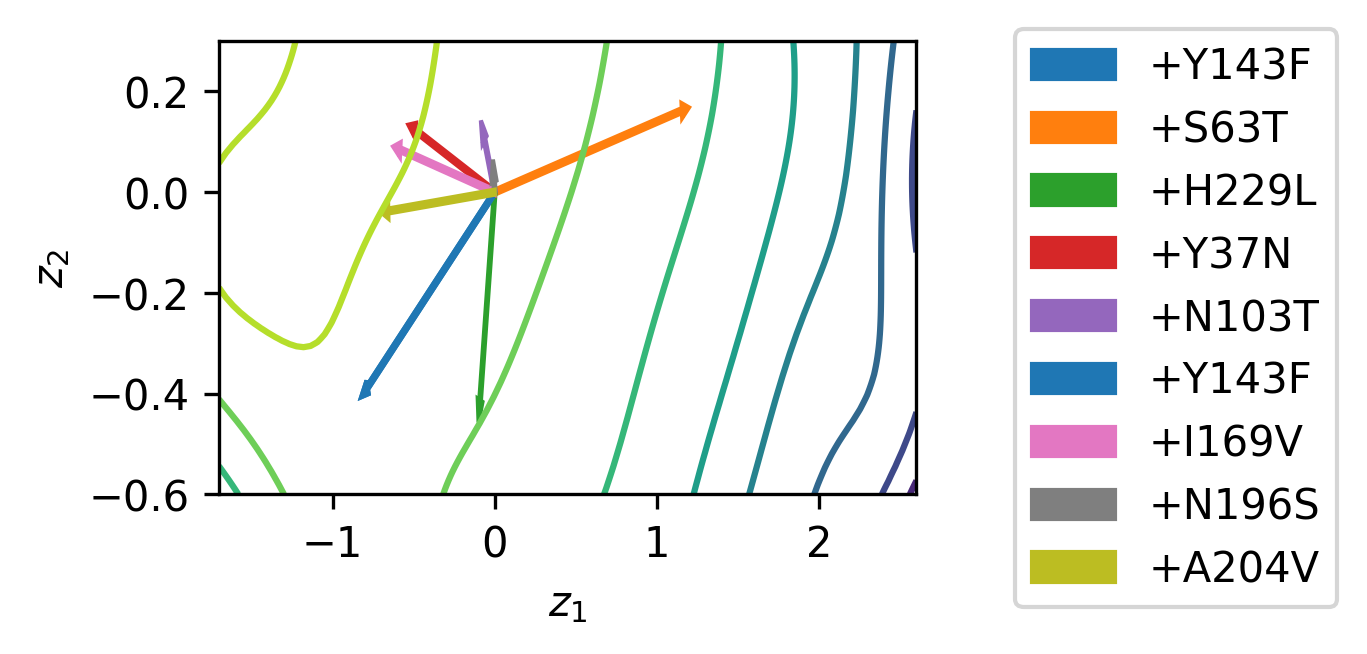

In [11]:
fig = plt.figure(figsize=(3, 2), dpi=300)

plt.contour(Z1, Z2, f, levels=8)

for i in ind:
    _z = W[i, [z1, z2]]
    plt.arrow(
        0,
        0,
        _z[0],
        _z[1],
        color="C{}".format(ind.index(i)),
        label="+{}".format(labels[ind.index(i)]),
        length_includes_head=True,
        width=0.01,
    )

fig.legend(                    
    ncol=1,                    
    bbox_to_anchor=(1.01, 0.9),
    loc="upper left",          
    borderaxespad=0.0,         
)

plt.xlabel("$z_1$")
plt.ylabel("$z_2$")

## Mutational effect distribution

To plot the distribution of effects learned by LANTERN in the two highest relevant dimension ($z_1$ and $z_2$), we compute the angle of each mutational effect vector and plot their histogram.

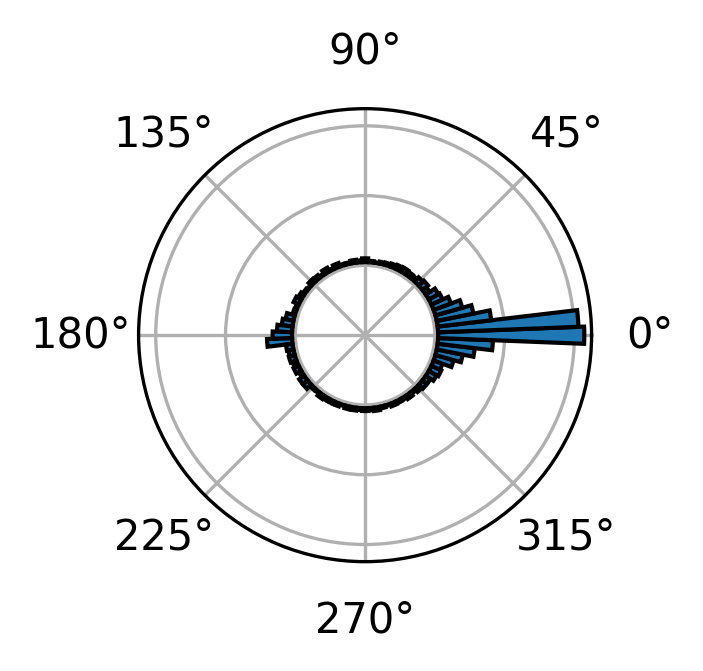

In [12]:
plt.figure(figsize=(2, 2), dpi=300)
ax = plt.subplot(111, polar=True)

# "y" is the first argument to arctan2
theta = np.arctan2(W[:, z2], W[:, z1])

H, edges = np.histogram(theta, bins=80, density=True)

ax = plt.subplot(111, polar="true")

# offset the bottom of the histogram
bottom = H.max() * 0.5

bars = ax.bar(
    edges[1:],
    H,
    width=edges[1:] - edges[:-1],
    bottom=bottom,
    zorder=100,
)
ax.set_yticklabels([])

for h, b in zip(H, bars):
    b.set_edgecolor("k")

## Model dimensions

To determine the dimensionality of the model, we find the highest $i$ such that $\log_{10} \sigma^2_k / \sigma^2_{k+1} > 1$. In other words, the lowest variance dimension that has at least a ten-fold increase in variance over the previous. This heuristic was sufficient to determine the correct landscape dimension for simulated data (see manuscript for more details). We show how to plot the fold change of dimensions, highlighting those that are included with this procedure.

In [13]:
# get basis dimension variances (inverse precision)
qalpha = model.basis.qalpha(detach=True)
sigmak = 1 / qalpha.mean[model.basis.order].numpy() # sort by the determined z1, z2, ...

[]

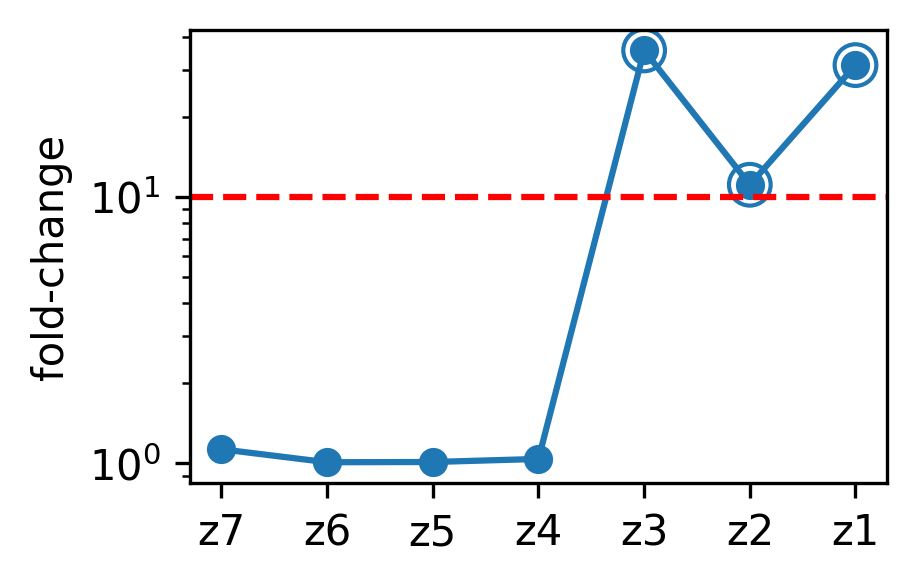

In [14]:
fold = (sigmak[:-1] / sigmak[1:])[::-1]
thresh = 1

# find the first dimension where at least a ten-fold change occurs
select = (np.where(np.log10(fold) > thresh)[0]).min()


plt.figure(figsize=(3, 2), dpi=300)
plt.plot(fold, marker="o")
plt.scatter(range(select, K-1), fold[select:], facecolors="none", s=100, edgecolors="C0")
plt.xticks(range(K-1), [f"z{K-k-1}" for k in range(K-1)])
plt.ylabel("fold-change")
plt.axhline(10**thresh, c="r", ls="--")

plt.semilogy()

We can also review the variance of each dimension directly. First looking at the total variance for each dimension:

Text(0, 0.5, '$\\sigma^2_k$')

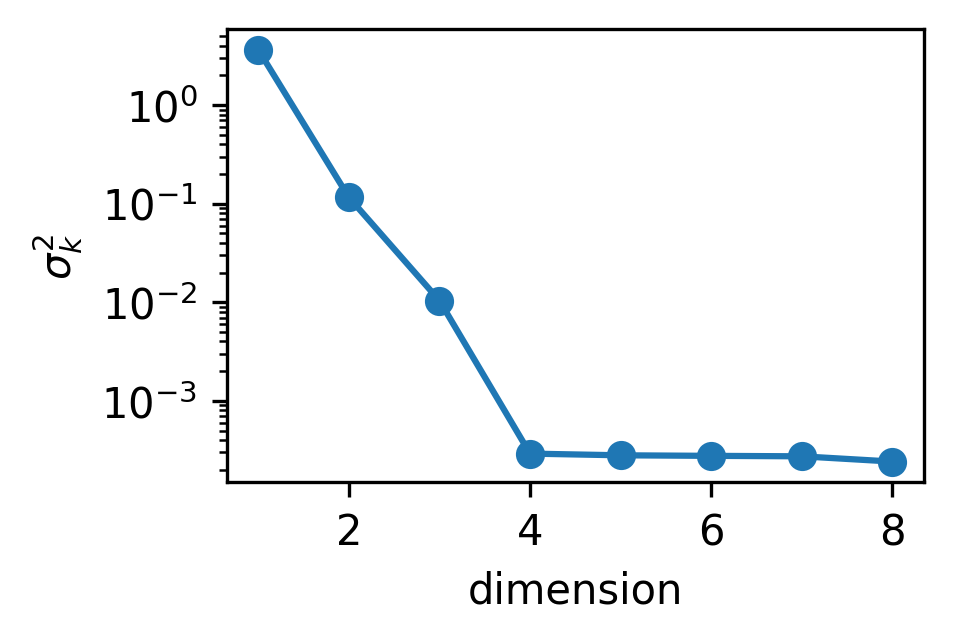

In [15]:
plt.figure(figsize=(3, 2), dpi=300)
plt.plot(np.arange(1, model.basis.K+1), sigmak, marker="o")
plt.semilogy()

plt.xlabel("dimension")
plt.ylabel("$\sigma^2_k$")

And also as a percentage of total variance for the mutational effect space:

Text(0, 0.5, '% total variance')

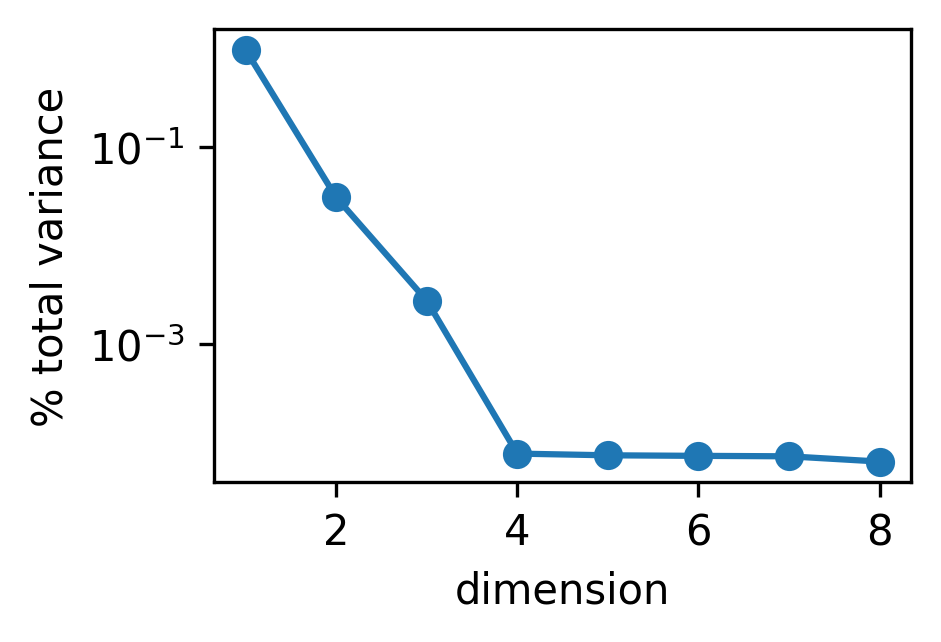

In [16]:
plt.figure(figsize=(3, 2), dpi=300)
plt.plot(np.arange(1, model.basis.K+1), sigmak / sigmak.sum(), marker="o")
plt.semilogy()

plt.xlabel("dimension")
plt.ylabel("% total variance")